In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
# set up the parameters of the class-conditioned Gaussian pdfs
mu_0 = np.array([-1, 1, -1, 1])
mu_1 = np.array([1, 1, 1, 1])

sigma_0 = np.array([[2, -0.5, 0.3, 0],
                    [-0.5, 1, -0.5, 0],
                    [0.3, -0.5, 1, 0],
                    [0, 0, 0, 2]])
sigma_1 = np.array([[1, 0.3, -0.2, 0],
                    [0.3, 2, 0.3, 0],
                    [-0.2, 0.3, 1, 0],
                    [0, 0, 0, 3]])

# set up the parameters of the class priors
p_0 = 0.7
p_1 = 0.3

In [3]:
# generate 10000 samples according to the data distribution
samples = 10000
x = np.random.multivariate_normal(mu_0, sigma_0, samples)
y = np.random.multivariate_normal(mu_1, sigma_1, samples)

# separate our final data set into data and labels
data = []
labels = []

# use the class priors to generate the labels
for i in range(samples):
    if np.random.rand() < p_0:
        data.append(x[i])
        labels.append(0)
    else:
        data.append(y[i])
        labels.append(1)

# convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [4]:
# set up the parameters of the loss matrix, using 0-1 loss
loss_matrix = np.array([[0, 1], [1, 0]])

### Part A
#### 1. Specify the minimum expected risk classification rule in the form of a likelihood ratio test where the threshold is a function of class priors and fixed loss values for each of the four possible outcomes

In [5]:
# return the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)
def likelihood_ratio_test(x: np.array, mu_0: np.array, mu_1: np.array, sigma_0: np.array, sigma_1: np.array) -> float:
    """
    Given a sample x, return the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)

    Args:
        x (np.array): a sample from the data distribution
        mu_0 (np.array): the mean of the class 0 Gaussian pdf
        mu_1 (np.array): the mean of the class 1 Gaussian pdf
        sigma_0 (np.array): the covariance matrix of the class 0 Gaussian pdf
        sigma_1 (np.array): the covariance matrix of the class 1 Gaussian pdf

    Returns:
        float: the ratio f_{X|Y}(x|1) / f_{X|Y}(x|0)
    """
    ratio_x_0 = multivariate_normal.pdf(x, mean=mu_0, cov=sigma_0)
    ratio_x_1 = multivariate_normal.pdf(x, mean=mu_1, cov=sigma_1)
    return ratio_x_1 / ratio_x_0

In [6]:
# define the minimum expected risk classification rule
def minimum_expected_risk_classification_rule(x: np.array, threshold: float, mu_0: np.array, mu_1: np.array, sigma_0: np.array, sigma_1: np.array) -> int:
    """
    Given a sample x and a threshold, return the classification of x according to the minimum expected risk classification rule

    Args:
        x (np.array): a sample from the data distribution
        mu_0 (np.array): the mean of the class 0 Gaussian pdf
        mu_1 (np.array): the mean of the class 1 Gaussian pdf
        sigma_0 (np.array): the covariance matrix of the class 0 Gaussian pdf
        sigma_1 (np.array): the covariance matrix of the class 1 Gaussian pdf
        threshold (float): the threshold for the likelihood ratio test

    Returns:
        int: the classification of x according to the minimum expected risk classification rule. 0 for class 0, 1 for class 1
    """
    if likelihood_ratio_test(x, mu_0, mu_1, sigma_0, sigma_1) >= threshold:
        return 1
    else:
        return 0

#### 2. Implement the classifier and apply it to the data set. Vary the threshold gradually from 0 to infinity and for each value of the threshold, compute the true positive rate and the false positive probabilities. Using these paired values, plot the ROC curve.

In [8]:
# obtain the true positive rate and false positive rate for each threshold for the ROC curve
def ROC_curve(data: np.array, labels: np.array, threshold: float, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> tuple[float, float]:
    """
    Given data, labels, and a threshold, return the true positive rate and false positive rate for the ROC curve

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        threshold (float): the threshold for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        tuple[float, float]: the true positive rate and false positive rate for the ROC curve
    """
    # initialize counters
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    # loop through data and labels
    for i in range(len(data)):
        if labels[i] == 1:
            if minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 1:
                true_positive += 1
            else:
                false_negative += 1
        else:
            if minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 1:
                false_positive += 1
            else:
                true_negative += 1
    
    # get the number of total positives
    total_positives = np.sum(labels)

    # compute the rates
    true_positive_rate = true_positive / total_positives
    false_positive_rate = false_positive / (false_positive + true_negative)

    # print the threshold and rates
    # print(f"threshold: {threshold}, true positive rate: {true_positive_rate}, false positive rate: {false_positive_rate}")
    
    return true_positive_rate, false_positive_rate


In [9]:
# have some constants for the ROC curve loop
thresholds = np.linspace(0, 1000, 1000, endpoint=False)

In [10]:
# Plot the ROC curve
true_positive_rate = []
false_positive_rate = []
for threshold in thresholds:
    roc = ROC_curve(data, labels, threshold)
    true_positive_rate.append(roc[0])
    false_positive_rate.append(roc[1])
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

KeyboardInterrupt: 

#### 3. Determine the threshold that minimizes the probability of error. On the ROC curve, superimpose the true positive and false positive probabilities for this minimum-P(error) threshold. Calculate and report an estimate of the minimum probability of error achievable for this data distribution

In [ ]:
# obtain the probability of error for each threshold that is only based on the data and not priors
def probability_of_error(data: np.array, labels: np.array, threshold: float, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> float:
    """
    Given data, labels, and a threshold, return the probability of error

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        threshold (float): the threshold for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        float: the probability of error
    """
    # initialize error counter
    error = 0

    # loop through data and labels
    for i in range(len(data)):
        if labels[i] == 1 and minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 0:
            error += 1
        elif labels[i] == 0 and minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 1:
            error += 1
    
    # compute the probability of error
    p_error = error / len(data)
    
    # print the threshold and probability of error
    # print(f"threshold: {threshold}, probability of error: {p_error}")
    
    # return the probability of error
    return p_error


threshold: 0.0, probability of error: 0.7092
threshold: 11.11111111111111, probability of error: 0.1176
threshold: 22.22222222222222, probability of error: 0.1347
threshold: 33.33333333333333, probability of error: 0.1467
threshold: 44.44444444444444, probability of error: 0.155
threshold: 55.55555555555556, probability of error: 0.1608
threshold: 66.66666666666666, probability of error: 0.1649
threshold: 77.77777777777777, probability of error: 0.1686
threshold: 88.88888888888889, probability of error: 0.1716
threshold: 100.0, probability of error: 0.1745


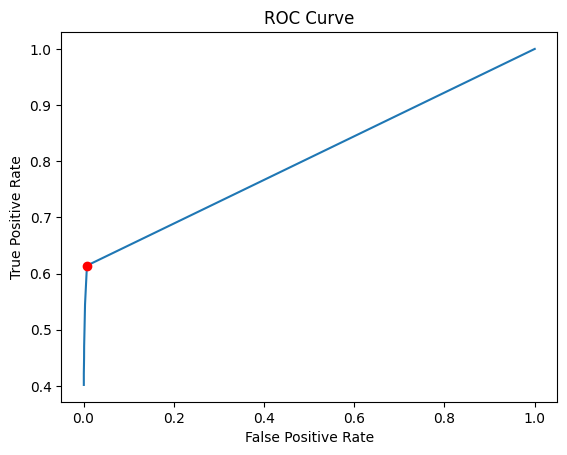

In [ ]:
# plot the minimum-P(error) threshold
min_error_threshold = 0
min_error = 1

for threshold in thresholds:
    error = probability_of_error(data, labels, threshold)
    if error < min_error:
        min_error = error
        min_error_threshold = threshold
        
# plot the ROC curve (previously determined) with the minimum-P(error) threshold
plt.plot(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate[np.where(thresholds == min_error_threshold)[0][0]], true_positive_rate[np.where(thresholds == min_error_threshold)[0][0]], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
# P(error; threshold) = P(D=1|Y=0)P(Y=0) + P(D=0|Y=1)P(Y=1)
def probability_of_error_optimal(data: np.array, labels: np.array, threshold: float, mu_0: np.array = mu_0, mu_1: np.array = mu_1, sigma_0: np.array = sigma_0, sigma_1: np.array = sigma_1) -> float:
    """
    Given data, labels, and a threshold, return the probability of error taking into account
    the priors and loss matrix

    Args:
        data (np.array): the data set
        labels (np.array): the labels for the data set
        threshold (float): the threshold for the likelihood ratio test
        mu_0 (np.array, optional): the mean of the class 0 Gaussian pdf. Defaults to mu_0.
        mu_1 (np.array, optional): the mean of the class 1 Gaussian pdf. Defaults to mu_1.
        sigma_0 (np.array, optional): the covariance matrix of the class 0 Gaussian pdf. Defaults to sigma_0.
        sigma_1 (np.array, optional): the covariance matrix of the class 1 Gaussian pdf. Defaults to sigma_1.

    Returns:
        float: the probability of error taking into account the priors and loss matrix
    """
    # initialize error counter
    error_0 = 0
    error_1 = 0

    # loop through data and labels
    for i in range(len(data)):
        if labels[i] == 1 and minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 0:
            error_1 += 1
        elif labels[i] == 0 and minimum_expected_risk_classification_rule(data[i], threshold, mu_0, mu_1, sigma_0, sigma_1) == 1:
            error_0 += 1

    # compute the probability of error
    p_error_0 = error_0 / len(data)
    p_error_1 = error_1 / len(data)

    # compute the probability of error taking into account the priors and loss matrix
    p_error = p_error_0 * p_0 * loss_matrix[0][1] + p_error_1 * p_1 * loss_matrix[1][0]
    
    # print the threshold and probability of error
    # print(f"threshold: {threshold}, probability of error with priors and loss matrix: {p_error}")
    
    # return the probability of error
    return p_error

In [ ]:
# determine the theoretical optimal threshold from priors and loss values
min_error_optimal_threshold = 0
min_error_optimal = 1

for threshold in thresholds:
    error = probability_of_error_optimal(data, labels, threshold)
    if error < min_error_optimal:
        min_error_optimal = error
        min_error_optimal_threshold = threshold

threshold: 0.0, probability of error with priors and loss matrix: 0.49644
threshold: 11.11111111111111, probability of error with priors and loss matrix: 0.037439999999999994
threshold: 22.22222222222222, probability of error with priors and loss matrix: 0.04137
threshold: 33.33333333333333, probability of error with priors and loss matrix: 0.04465
threshold: 44.44444444444444, probability of error with priors and loss matrix: 0.0469
threshold: 55.55555555555556, probability of error with priors and loss matrix: 0.04859999999999999
threshold: 66.66666666666666, probability of error with priors and loss matrix: 0.04975
threshold: 77.77777777777777, probability of error with priors and loss matrix: 0.05078
threshold: 88.88888888888889, probability of error with priors and loss matrix: 0.051680000000000004
threshold: 100.0, probability of error with priors and loss matrix: 0.05255


In [ ]:
# print the estimated minimum probability of error
print("The estimated minimum probability of error is: ", min_error_optimal)
# print the empirical selected threshold
print("The empirical selected threshold is: ", min_error_threshold)
# print the theoretical optimal threshold
print("The theoretical optimal threshold is: ", min_error_optimal_threshold)

The estimated minimum probability of error is:  0.037439999999999994
The empirical selected threshold is:  11.11111111111111
The theoretical optimal threshold is:  11.11111111111111


### Part B: ERM classification using incorrect knowledge of data distribution
#### Assume we know the true class priors, but the class conditional pdfs are both gaussian with true means but the covariance matrices are diagonal (with diagonal entries equal to true variances, but the off-diagonal entries are zero). Analyze the impact of this model mismatch by implementing the ERM classification rule using the incorrect model. Repeat the same steps in part a on the same data set

In [ ]:
# set up the diagonal covariance matrices
sigma_0_incorrect = np.array([[2, 0, 0, 0],
                              [0, 1, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 2]])
sigma_1_incorrect = np.array([[1, 0, 0, 0],
                              [0, 2, 0, 0],
                              [0, 0, 1, 0],
                              [0, 0, 0, 3]])

threshold: 0.0, true positive rate: 1.0, false positive rate: 1.0
threshold: 11.11111111111111, true positive rate: 0.6506189821182944, false positive rate: 0.025380710659898477
threshold: 22.22222222222222, true positive rate: 0.5257909215955984, false positive rate: 0.01311336717428088
threshold: 33.33333333333333, true positive rate: 0.4442916093535076, false positive rate: 0.009447264523406655
threshold: 44.44444444444444, true positive rate: 0.39270976616231085, false positive rate: 0.00775521714608009
threshold: 55.55555555555556, true positive rate: 0.35488308115543327, false positive rate: 0.005922165820642978
threshold: 66.66666666666666, true positive rate: 0.3263411279229711, false positive rate: 0.005076142131979695
threshold: 77.77777777777777, true positive rate: 0.2995185694635488, false positive rate: 0.00437112239142696
threshold: 88.88888888888889, true positive rate: 0.28026134800550206, false positive rate: 0.0038071065989847717
threshold: 100.0, true positive rate:

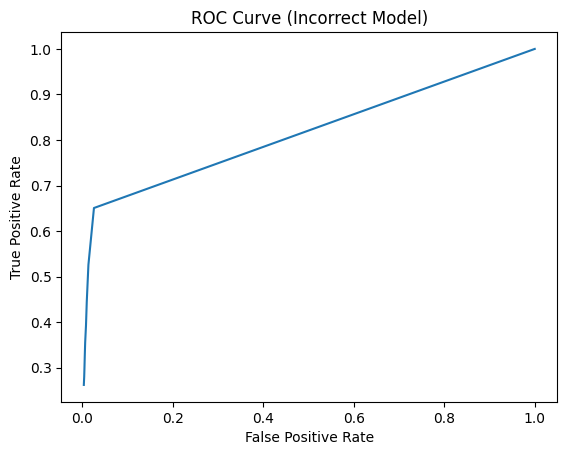

In [ ]:
# Plot the ROC curve for the incorrect model
true_positive_rate_incorrect = []
false_positive_rate_incorrect = []
for threshold in thresholds:
    roc = ROC_curve(data, labels, threshold, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)
    true_positive_rate_incorrect.append(roc[0])
    false_positive_rate_incorrect.append(roc[1])
plt.plot(false_positive_rate_incorrect, true_positive_rate_incorrect)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Incorrect Model)')
plt.show()

threshold: 0.0, probability of error: 0.7092
threshold: 11.11111111111111, probability of error: 0.1196
threshold: 22.22222222222222, probability of error: 0.1472
threshold: 33.33333333333333, probability of error: 0.1683
threshold: 44.44444444444444, probability of error: 0.1821
threshold: 55.55555555555556, probability of error: 0.1918
threshold: 66.66666666666666, probability of error: 0.1995
threshold: 77.77777777777777, probability of error: 0.2068
threshold: 88.88888888888889, probability of error: 0.212
threshold: 100.0, probability of error: 0.2167


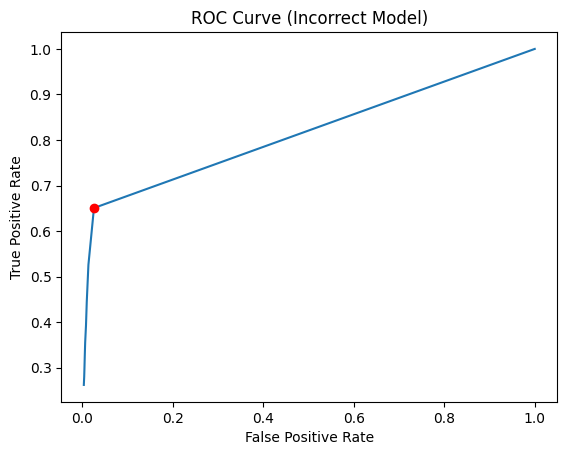

In [ ]:
# plot the minimum-P(error) threshold for the incorrect model
min_error_threshold_incorrect = 0
min_error_incorrect = 1

for threshold in thresholds:
    error = probability_of_error(data, labels, threshold, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)
    if error < min_error_incorrect:
        min_error_incorrect = error
        min_error_threshold_incorrect = threshold
        
# plot the ROC curve (previously determined) with the minimum-P(error) threshold
plt.plot(false_positive_rate_incorrect, true_positive_rate_incorrect)
plt.plot(false_positive_rate_incorrect[np.where(thresholds == min_error_threshold_incorrect)[0][0]], true_positive_rate_incorrect[np.where(thresholds == min_error_threshold_incorrect)[0][0]], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Incorrect Model)')
plt.show()

In [ ]:
# determine the theoretical optimal threshold from priors and loss values for the incorrect model
min_error_optimal_threshold_incorrect = 0
min_error_optimal_incorrect = 1

for threshold in thresholds:
    error = probability_of_error_optimal(data, labels, threshold, mu_0, mu_1, sigma_0_incorrect, sigma_1_incorrect)
    if error < min_error_optimal_incorrect:
        min_error_optimal_incorrect = error
        min_error_optimal_threshold_incorrect = threshold

threshold: 0.0, probability of error with priors and loss matrix: 0.49644
threshold: 11.11111111111111, probability of error with priors and loss matrix: 0.04307999999999999
threshold: 22.22222222222222, probability of error with priors and loss matrix: 0.04788
threshold: 33.33333333333333, probability of error with priors and loss matrix: 0.053169999999999995
threshold: 44.44444444444444, probability of error with priors and loss matrix: 0.05683
threshold: 55.55555555555556, probability of error with priors and loss matrix: 0.059219999999999995
threshold: 66.66666666666666, probability of error with priors and loss matrix: 0.06129
threshold: 77.77777777777777, probability of error with priors and loss matrix: 0.06328
threshold: 88.88888888888889, probability of error with priors and loss matrix: 0.06468
threshold: 100.0, probability of error with priors and loss matrix: 0.06585


In [ ]:
# print the estimated minimum probability of error for the incorrect model
print("The estimated minimum probability of error with the incorrect model is: ", min_error_optimal_incorrect)
# print the empirical selected threshold for the incorrect model
print("The empirical selected threshold with the incorrect model is: ", min_error_threshold_incorrect)
# print the theoretical optimal threshold for the incorrect model
print("The theoretical optimal threshold with the incorrect model is: ", min_error_optimal_threshold_incorrect)

The estimated minimum probability of error with the incorrect model is:  0.04307999999999999
The empirical selected threshold with the incorrect model is:  11.11111111111111
The theoretical optimal threshold with the incorrect model is:  11.11111111111111


# TODO: rerun the data on a larger linspace
# TODO: answer the question about how does the empirical vs theoretical compare for both the correct and incorrect models
# TODO: answer the last question about model mismatch